<a href="https://colab.research.google.com/github/surajjorwar/Road-way-inspection-system-/blob/main/final_year_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Install Dependencies and Setup

In [2]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.3
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

In [7]:
data_dir = '/content/drive/MyDrive/data'

In [8]:
image_exts = ['jpg', 'bmp', 'png']

In [9]:
 os.listdir(data_dir)

['normal', 'potholes']

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/data')

Found 682 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
data_iterator

In [14]:
batch = data_iterator.next()

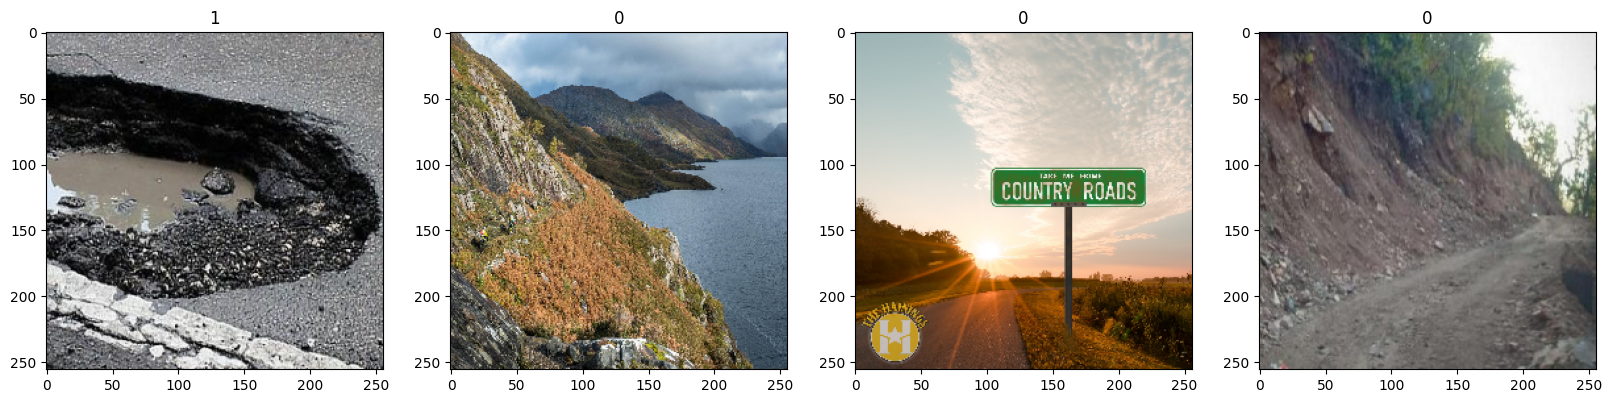

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [16]:
data = data.map(lambda x,y: (x/255, y))

In [17]:
data.as_numpy_iterator().next()

(array([[[[0.3732843 , 0.43210784, 0.52230394],
          [0.38757852, 0.44640204, 0.5365981 ],
          [0.39044118, 0.4492647 , 0.5394608 ],
          ...,
          [0.29200175, 0.35866842, 0.46062922],
          [0.28621325, 0.3528799 , 0.4548407 ],
          [0.28976142, 0.3564281 , 0.45838886]],
 
         [[0.39828432, 0.45710784, 0.5473039 ],
          [0.40931374, 0.46813726, 0.55833334],
          [0.41213235, 0.47095588, 0.561152  ],
          ...,
          [0.28970587, 0.36629903, 0.4715686 ],
          [0.27628675, 0.3528799 , 0.45814952],
          [0.27072802, 0.34732115, 0.45259076]],
 
         [[0.41629902, 0.47512254, 0.56213236],
          [0.42671567, 0.48553923, 0.57254905],
          [0.43288335, 0.49170688, 0.5787167 ],
          ...,
          [0.29050246, 0.3690353 , 0.4846201 ],
          [0.26902   , 0.34675246, 0.46583372],
          [0.26203853, 0.34049863, 0.45640126]],
 
         ...,
 
         [[0.31987593, 0.2845818 , 0.25394455],
          [0.35725

# 5. Split Data

In [18]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [19]:
train_size

15

In [20]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [21]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [23]:
model = Sequential()

In [24]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [25]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [27]:
logdir='logs'

In [28]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
hist = model.fit(train, epochs=14, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/14
15/15 [==============================] - 103s 6s/step - loss: 0.7867 - accuracy: 0.5312 - val_loss: 0.6722 - val_accuracy: 0.5078
Epoch 2/14
15/15 [==============================] - 90s 5s/step - loss: 0.5361 - accuracy: 0.7063 - val_loss: 0.4315 - val_accuracy: 0.8203
Epoch 3/14
15/15 [==============================] - 92s 6s/step - loss: 0.3617 - accuracy: 0.8313 - val_loss: 0.2822 - val_accuracy: 0.8906
Epoch 4/14
15/15 [==============================] - 93s 6s/step - loss: 0.2910 - accuracy: 0.8687 - val_loss: 0.2438 - val_accuracy: 0.8750
Epoch 5/14
15/15 [==============================] - 90s 5s/step - loss: 0.2812 - accuracy: 0.8833 - val_loss: 0.2419 - val_accuracy: 0.9062
Epoch 6/14
15/15 [==============================] - 89s 5s/step - loss: 0.2787 - accuracy: 0.8687 - val_loss: 0.3238 - val_accuracy: 0.8672
Epoch 7/14
15/15 [==============================] - 73s 4s/step - loss: 0.1833 - accuracy: 0.9167 - val_loss: 0.1445 - val_accuracy: 0.9297
Epoch 8/14
15/15 [=

# 8. Plot Performance

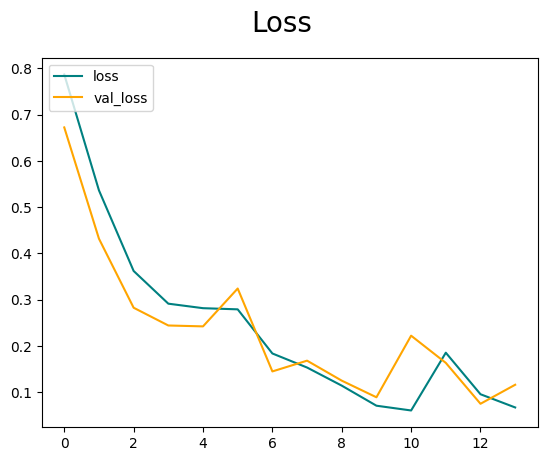

In [30]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

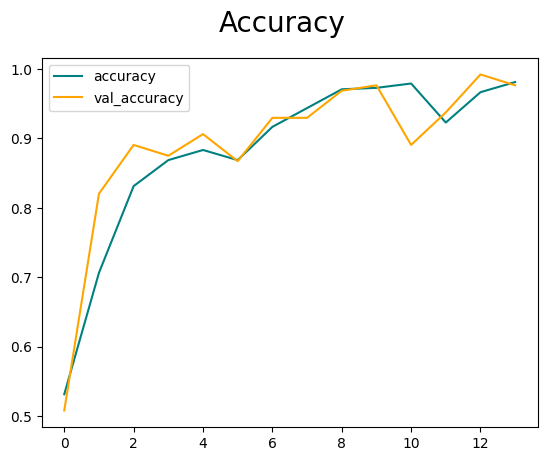

In [31]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [32]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [33]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [34]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 452ms/step


In [35]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.969697, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.984375, shape=(), dtype=float32)


# 10. Test

In [36]:
import cv2

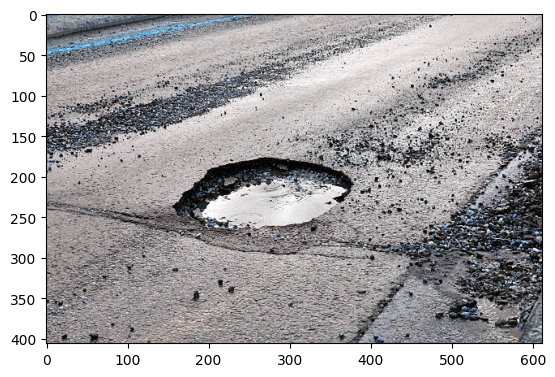

In [37]:
img = cv2.imread('/content/potholeimg.jpg')
plt.imshow(img)
plt.show()

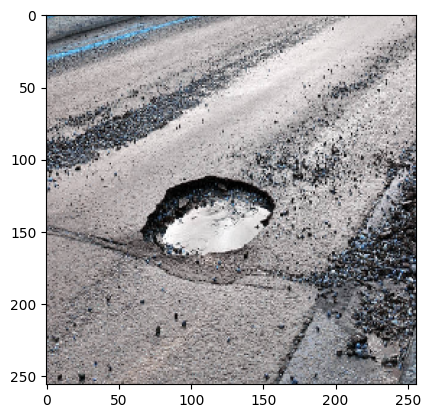

In [38]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [39]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 113ms/step


In [40]:
yhat

array([[0.95793223]], dtype=float32)

In [41]:
if yhat > 0.5:
    print(f'POTHOLE')
else:
    print(f'PLAIN')

POTHOLE


In [42]:
import cv2
import tensorflow as tf
import numpy as np

def predict_pothole(image_path, model):
    # Load the image using OpenCV
    img = cv2.imread(image_path)

    # Resize the image using TensorFlow
    resize = tf.image.resize(img, (256, 256))

    # Preprocess the resized image
    processed_image = np.expand_dims(resize / 255, 0)

    # Make a prediction on the processed image
    prediction = model.predict(processed_image)

    # Check if the prediction is greater than 0.5
    if prediction > 0.5:
        return 'POTHOLE'
    else:
        return 'PLAIN'


In [43]:
path = '/content/potholeimg.jpg'

In [44]:
predict_pothole(path,model)

1/1 [==============================] - 0s 42ms/step


'POTHOLE'

SPEED BREAKER


In [45]:
data_dir2 = '/content/drive/MyDrive/potholes'

In [46]:
image_exts = ['jpg', 'bmp', 'png']

In [47]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [48]:
 os.listdir(data_dir2)

['nor', 'speed breaker']

In [49]:
data2 = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/potholes')

Found 599 files belonging to 2 classes.


In [50]:
data_iterator2 = data2.as_numpy_iterator()

In [51]:
data_iterator2

In [52]:
batch2 = data_iterator2.next()

In [53]:
data2 = data2.map(lambda x,y: (x/255, y))

In [54]:
data2.as_numpy_iterator().next()

(array([[[[0.00902267, 0.08235294, 0.10116421],
          [0.00784314, 0.08550858, 0.09571078],
          [0.02117034, 0.11216299, 0.10549939],
          ...,
          [0.5414982 , 0.5317402 , 0.33837315],
          [0.5706342 , 0.5753217 , 0.41848958],
          [0.5157322 , 0.5263174 , 0.32284006]],
 
         [[0.01176471, 0.08235294, 0.12558211],
          [0.00784314, 0.10903799, 0.10703125],
          [0.00507047, 0.11410846, 0.1243413 ],
          ...,
          [0.46427697, 0.5204197 , 0.2898131 ],
          [0.4879136 , 0.5009191 , 0.3078125 ],
          [0.5639399 , 0.5823989 , 0.42553616]],
 
         [[0.18337929, 0.25399816, 0.12974878],
          [0.20860907, 0.29682904, 0.18443628],
          [0.24007353, 0.31461397, 0.19443934],
          ...,
          [0.43949142, 0.47666973, 0.24545036],
          [0.4844516 , 0.5295037 , 0.32363665],
          [0.45298713, 0.49813113, 0.27666974]],
 
         ...,
 
         [[0.21574755, 0.27849266, 0.11980698],
          [0.26289

In [55]:
train_size = int(len(data2)*.7)
val_size = int(len(data2)*.2)
test_size = int(len(data2)*.1)

In [56]:
train_size

13

In [57]:
train = data2.take(train_size)
val = data2.skip(train_size).take(val_size)
test = data2.skip(train_size+val_size).take(test_size)

In [58]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [60]:
model2 = Sequential()

In [61]:
model2.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model2.add(MaxPooling2D())
model2.add(Conv2D(32, (3,3), 1, activation='relu'))
model2.add(MaxPooling2D())
model2.add(Conv2D(16, (3,3), 1, activation='relu'))
model2.add(MaxPooling2D())
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [62]:
model2.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [63]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

In [64]:
logdir='logs'

In [65]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [66]:
hist2 = model2.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5
13/13 [==============================] - 60s 4s/step - loss: 0.5060 - accuracy: 0.7163 - val_loss: 0.4307 - val_accuracy: 0.7812
Epoch 2/5
13/13 [==============================] - 54s 4s/step - loss: 0.2894 - accuracy: 0.8606 - val_loss: 0.1999 - val_accuracy: 0.9583
Epoch 3/5
13/13 [==============================] - 54s 4s/step - loss: 0.3007 - accuracy: 0.8966 - val_loss: 0.3066 - val_accuracy: 0.8750
Epoch 4/5
13/13 [==============================] - 54s 4s/step - loss: 0.2343 - accuracy: 0.9014 - val_loss: 0.1259 - val_accuracy: 0.9479
Epoch 5/5
13/13 [==============================] - 57s 4s/step - loss: 0.1536 - accuracy: 0.9495 - val_loss: 0.1355 - val_accuracy: 0.9688


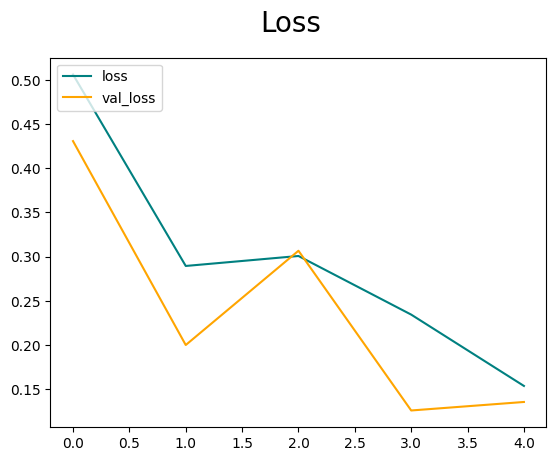

In [67]:
fig = plt.figure()
plt.plot(hist2.history['loss'], color='teal', label='loss')
plt.plot(hist2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

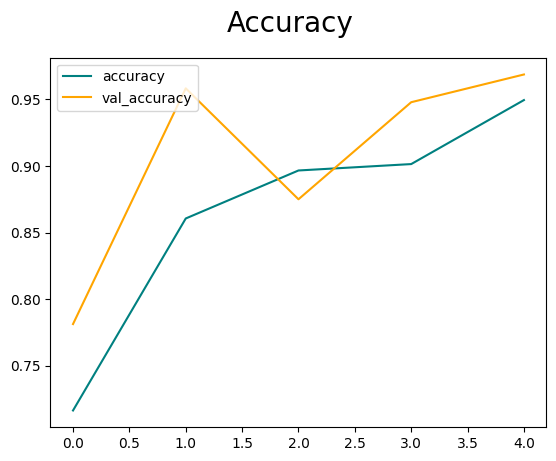

In [68]:
fig = plt.figure()
plt.plot(hist2.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist2.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [69]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [70]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [71]:
for batch2 in test.as_numpy_iterator():
    X, y = batch2
    yhat2 = model2.predict(X)
    pre.update_state(y, yhat2)
    re.update_state(y, yhat2)
    acc.update_state(y, yhat2)

1/1 [==============================] - 1s 645ms/step


In [72]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.90909094, shape=(), dtype=float32) tf.Tensor(0.96875, shape=(), dtype=float32)


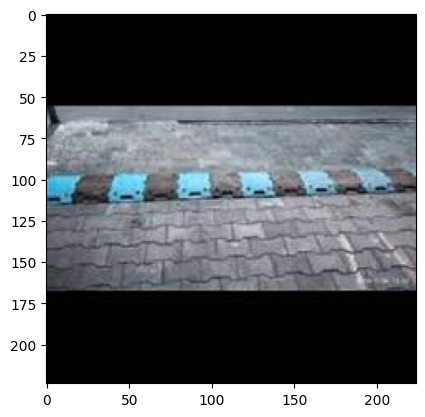

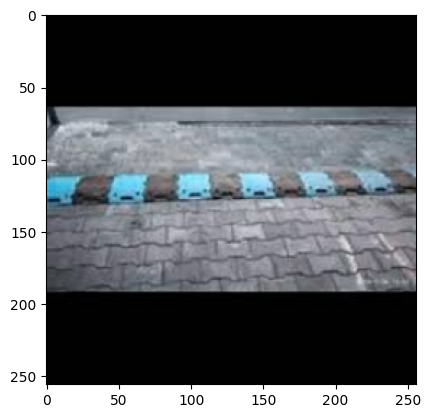

In [73]:
img = cv2.imread('/content/images (28).jpeg')
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [74]:
yhat2 = model2.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 100ms/step


In [75]:
yhat2

array([[0.9682987]], dtype=float32)

In [76]:
if yhat2 > 0.5:
    print(f'SPEEDBREAKER')
else:
    print(f'PLAIN')

SPEEDBREAKER


In [77]:
import cv2
import tensorflow as tf
import numpy as np

def predict_image_type(image_path, model, model2):
    # Load the image using OpenCV
    img = cv2.imread(image_path)

    # Resize the image using TensorFlow
    resize = tf.image.resize(img, (256, 256))

    # Preprocess the resized image
    processed_image = np.expand_dims(resize / 255, 0)

    # Make a prediction on the processed image using model
    yhat = model.predict(processed_image)


    yhat2 = model2.predict(processed_image)




    if yhat > yhat2:
       yhat > 0.5
       return 'POTHOLE'

    elif yhat2 > 0.5:
      yhat2 > 0.5
      return 'SPEEDBREAKER'
    else:

      return 'PLAIN'


In [93]:
path = '/content/images (28).jpeg'

In [94]:
predict_image_type(path, model, model2)

1/1 [==============================] - 0s 37ms/step


'SPEEDBREAKER'